In [1]:
import argparse
import os
import time

import glog, json

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'

import torch
import torch.multiprocessing as mp
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.modeling_attn_mask_utils import \
    _prepare_4d_causal_attention_mask

from lib import utils
from lib.algo import finetune
from lib.codebook import bitshift
from operator import attrgetter

import sys
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))

from NWC.models import get_model

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)


def load_comp_model(comp_model_path):
    config = os.path.join(os.path.dirname(comp_model_path), 'config.json')
    with open(config, 'r', encoding='utf-8') as file:
        config = json.load(file)
    config = Config(**config)

    shift, scale = None, None
    if config.architecture == 'nwc_ql' and not hasattr(config, "Q"):
        config.Q = 4
    if not hasattr(config, "no_layernorm"):
        config.no_layernorm = False
        
    comp_model = get_model(config.architecture, config, scale=scale, shift=shift)      
    ckpt = torch.load(comp_model_path, weights_only=False)
    if True:
        # try:
        #     scale = ckpt["state_dict"]["scale"]
        #     shift = ckpt["state_dict"]["shift"]
        #     print('Use train scale and shift')
        #     print('shift: ', shift, ' scale:', scale)
        # except:
            scale, shift  = torch.ones(1), torch.zeros(1)
    else:
        if 'scale' in ckpt["state_dict"]:
            del ckpt["state_dict"]['scale']
        if 'shift' in ckpt["state_dict"]:
            del ckpt["state_dict"]['shift']
        shift, scale = utils.get_model_weight_stats(model, args, config.input_size)
    print('shift: ', shift, ' scale:', scale)

    comp_model.load_state_dict(ckpt["state_dict"], strict = False)
    comp_model.scale = scale
    comp_model.shift = shift
    comp_model.eval()
    comp_model.update()
    
    return comp_model

W1106 18:47:53.032850 2146254 warnings.py:109] /opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

I1106 18:47:53.617095 2146254 utils.py:148] Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
I1106 18:47:53.618850 2146254 utils.py:151] Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
I1106 18:47:53.619635 2146254 utils.py:164] NumExpr defaulting to 16 threads.
W1106 18:47:54.855839 2146254 warnings.py:109] /opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality

In [2]:
import glob
import re
import math

def extract_lmbda(path):
    match = re.search(r'lmbda(\d+)', path)
    return int(match.group(1)) if match else 0

# search_dir = '/home/jgryu/workspace/weight_compression/NWC/checkpoint/nwc_ql/block_seq_ql_random_scaler_meta-llama--Meta-Llama-3-8B__col_1024_gaussian_padding.pt/M16/'
# search_dir = '/home/jgryu/workspace/weight_compression/NWC/checkpoint/nwc_ql/block_seq_ql_random_scaler_meta-llama--Meta-Llama-3-8B__col_1024_gaussian_padding.pt/ablation_mse_rdloss_ql_mse_size16_encdim512_M16_Q4_R0_m0_batch_size2048_total_iter200000_lr0.0001_seed100'
search_dirs = [
    '/home/jgryu/workspace/weight_compression/NWC/checkpoint/nwc_ql/block_seq_ql_random_scaler_meta-llama--Meta-Llama-3-8B__col_1024_gaussian_padding.pt/M16',
    # '/home/jgryu/workspace/weight_compression/NWC/checkpoint/nwc_ql/block_seq_ql_random_scaler_meta-llama--Meta-Llama-3-8B__col_1024_gaussian_padding.pt/double_check_rdloss_ql_size16_encdim512_M16_Q4_R0_m0_batch_size2048_total_iter200000_lr0.0001_seed100',
    '/home/jgryu/workspace/weight_compression/NWC/checkpoint/nwc_ql/block_seq_ql_random_scaler_meta-llama--Meta-Llama-3-8B__col_1024_gaussian_padding.pt/ablation_mse_rdloss_ql_mse_size16_encdim512_M16_Q4_R0_m0_batch_size2048_total_iter200000_lr0.0001_seed100',
    '/home/jgryu/workspace/weight_compression/NWC/checkpoint/nwc_ql/block_seq_ql_random_scaler_meta-llama--Meta-Llama-3-8B__col_1024_gaussian_padding.pt/ablation_ql_rdloss_ql_v2_size16_encdim512_M16_Q4_R0_m0_batch_size2048_total_iter200000_lr0.0001_seed100',
    # '/home/jgryu/workspace/weight_compression/NWC/checkpoint/nwc_ql/block_seq_ql_random_scaler_meta-llama--Meta-Llama-3-8B__col_1024_gaussian_padding.pt/ablation_mse_rdloss_ql_mse_size16_encdim512_M16_Q4_R0_m0_batch_size2048_total_iter200000_lr1e-05_seed100',
    '/home/jgryu/workspace/weight_compression/NWC/checkpoint/nwc_ql/block_seq_ql_random_scaler_meta-llama--Meta-Llama-3-8B__col_1024_gaussian_padding.pt/ablation_mse_rdloss_ql_mse_size16_encdim512_M16_Q4_R0_m0_batch_size2048_total_iter200000_lr0.0001_seed100',
    '/home/jgryu/workspace/weight_compression/NWC/checkpoint/nwc_ql/block_seq_ql_random_scaler_meta-llama--Meta-Llama-3-8B__col_1024_gaussian_padding.pt/ablation_rate_bpp_3.4_rdloss_ql_mse_size16_encdim512_M16_Q4_R0_m0_batch_size2048_total_iter200000_lr0.0001_seed100'
]
W = torch.randn(2, 4096, 16).cuda()


result = {}
for search_dir in search_dirs:
    exp_name = search_dir.split('/')[-1]
    exp_name = '_'.join(exp_name.split('_')[:2])
    result[exp_name] = {}
    print(exp_name)
    
    search_pattern = os.path.join(search_dir, 'lmbda*/best_loss*')
    path_list = glob.glob(search_pattern, recursive=True)
    path_list_sorted = sorted(path_list, key=extract_lmbda)
    
    
    for comp_model_path in path_list_sorted:
        match = re.search(r'lmbda(\d+)', comp_model_path)
        if match:
            lmbda_value = match.group(1)
            # print(f'comp_model_path: {comp_model_path}')
            print(f'lmbda: {lmbda_value}')
        else:
            # print(f'comp_model_path: {comp_model_path}')
            print('lmbda 값 찾을 수 없음')
        comp_model = load_comp_model(comp_model_path)
        
        result[exp_name][lmbda_value] = {}
        
        comp_model.scale = comp_model.scale.cuda()
        comp_model.shift = comp_model.shift.cuda()
        comp_model = comp_model.cuda()

        
        for q in range(4):
            data = {}
            data['weight_block'] = W
            data['q_level'] = torch.full((1, 1, 1), q).to(int).cuda()

            out = comp_model(data)
            W_hat = out['x_hat'].reshape(W.shape)
            mse = ((W_hat - W) ** 2).mean().item()
            bpp_loss = (torch.log(out["likelihoods"]).sum() / -math.log(2)) / W.numel()
            # mse_list.append(mse)
            
            result[exp_name][lmbda_value][f'ql_{q}'] = {'mse': mse, 'bpp': bpp_loss.item()}
            
        # print(" ".join([f"Q={q} MSE: {mse_list[q]/mse_list[-1]:.2f}" for q in range(4)]))
        # print(" ".join([f"Q={q} MSE: {mse_list[q]*1000:.2f}" for q in range(4)]))

M16
lmbda: 5
shift:  tensor([0.])  scale: tensor([1.])
lmbda: 10
shift:  tensor([0.])  scale: tensor([1.])
lmbda: 30
shift:  tensor([0.])  scale: tensor([1.])
lmbda: 50
shift:  tensor([0.])  scale: tensor([1.])
lmbda: 100
shift:  tensor([0.])  scale: tensor([1.])
lmbda: 300
shift:  tensor([0.])  scale: tensor([1.])
lmbda: 1000
shift:  tensor([0.])  scale: tensor([1.])
lmbda: 10000
shift:  tensor([0.])  scale: tensor([1.])
lmbda: 100000
shift:  tensor([0.])  scale: tensor([1.])
lmbda: 1000000
shift:  tensor([0.])  scale: tensor([1.])
lmbda: 3000000
shift:  tensor([0.])  scale: tensor([1.])
ablation_mse
lmbda: 5
shift:  tensor([0.])  scale: tensor([1.])
lmbda: 10
shift:  tensor([0.])  scale: tensor([1.])
lmbda: 20
shift:  tensor([0.])  scale: tensor([1.])
lmbda: 30
shift:  tensor([0.])  scale: tensor([1.])
lmbda: 50
shift:  tensor([0.])  scale: tensor([1.])
lmbda: 100
shift:  tensor([0.])  scale: tensor([1.])
lmbda: 300
shift:  tensor([0.])  scale: tensor([1.])
lmbda: 1000
shift:  tensor

Starting data transformation for plotting...
DataFrame created successfully.
Generating Matplotlib plot...


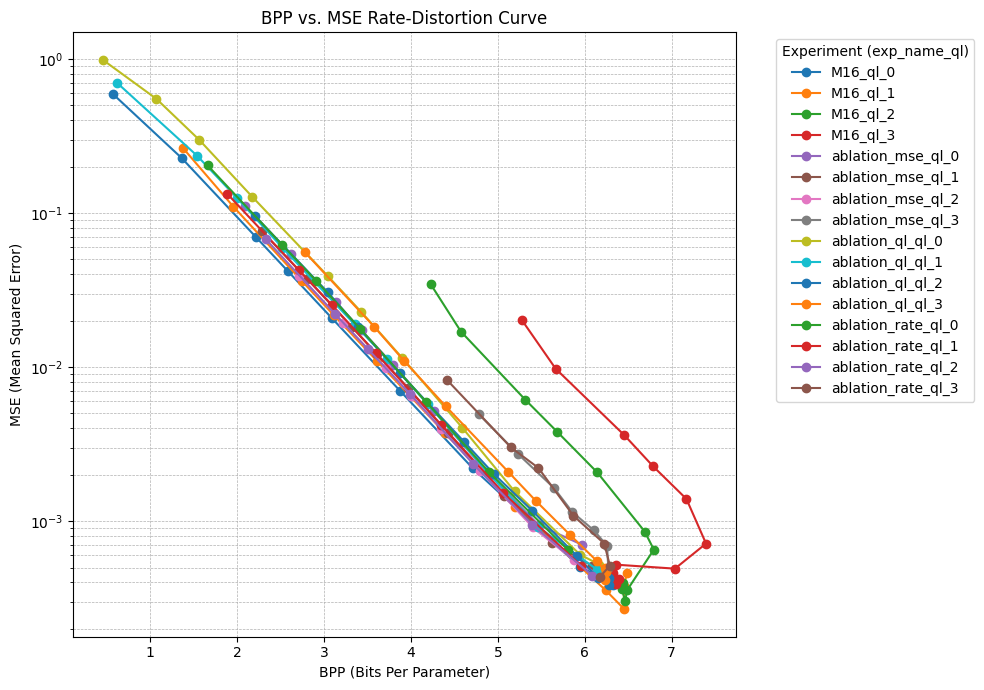

Chart saved successfully to bpp_vs_mse_curve_matplotlib.png


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("Starting data transformation for plotting...")

# 1. 중첩된 딕셔너리를 리스트로 변환
data_list = []
for exp_name, lmbda_dict in result.items():
    for lmbda_value, ql_dict in lmbda_dict.items():
        for q_level, metrics in ql_dict.items():
            data_list.append({
                'exp_name': exp_name,
                'lmbda': lmbda_value,
                'q_level': q_level,
                'mse': metrics['mse'],
                'bpp': metrics['bpp']
            })

# 2. 리스트를 pandas DataFrame으로 변환
df = pd.DataFrame(data_list)

# 3. 데이터 정리 및 준비
df['lmbda'] = df['lmbda'].astype(int) # 정렬을 위해 lmbda를 정수형으로
df['curve_label'] = df['exp_name'] + '_' + df['q_level'] # 범례에 사용할 라벨

print("DataFrame created successfully.")

# 4. Matplotlib 플롯 생성
print("Generating Matplotlib plot...")
fig, ax = plt.subplots(figsize=(10, 7))

# 5. 각 커브(라인)별로 반복
unique_labels = df['curve_label'].unique()

for label in unique_labels:
    # 현재 라벨에 해당하는 데이터만 선택
    subset = df[df['curve_label'] == label]
    
    # 중요: lmbda 값에 따라 점들을 정렬하여 라인이 올바르게 연결되도록 함
    subset = subset.sort_values(by='lmbda')
    
    # x축(bpp), y축(mse) 데이터
    x_values = subset['bpp']
    y_values = subset['mse']
    
    # 플롯
    ax.plot(x_values, y_values, marker='o', linestyle='-', label=label)

# 6. 플롯 꾸미기
ax.set_yscale('log') # Y축을 로그 스케일로 (RD 커브에 일반적)
ax.set_xlabel('BPP (Bits Per Parameter)')
ax.set_ylabel('MSE (Mean Squared Error)')
ax.set_title('BPP vs. MSE Rate-Distortion Curve')

# 범례(Legend)를 플롯 바깥쪽에 배치 (라인이 많을 경우 유용)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Experiment (exp_name_ql)')

ax.grid(True, which='both', linestyle='--', linewidth=0.5)
fig.tight_layout() # 레이아웃 최적화

# 7. 플롯 저장 및 표시
plot_filename = 'bpp_vs_mse_curve_matplotlib.png'
plt.savefig(plot_filename, bbox_inches='tight') # bbox_inches='tight'로 범례가 잘리지 않게 저장
plt.show()

print(f"Chart saved successfully to {plot_filename}")

DataFrame created successfully.
Generating Matplotlib 2x2 subplot...


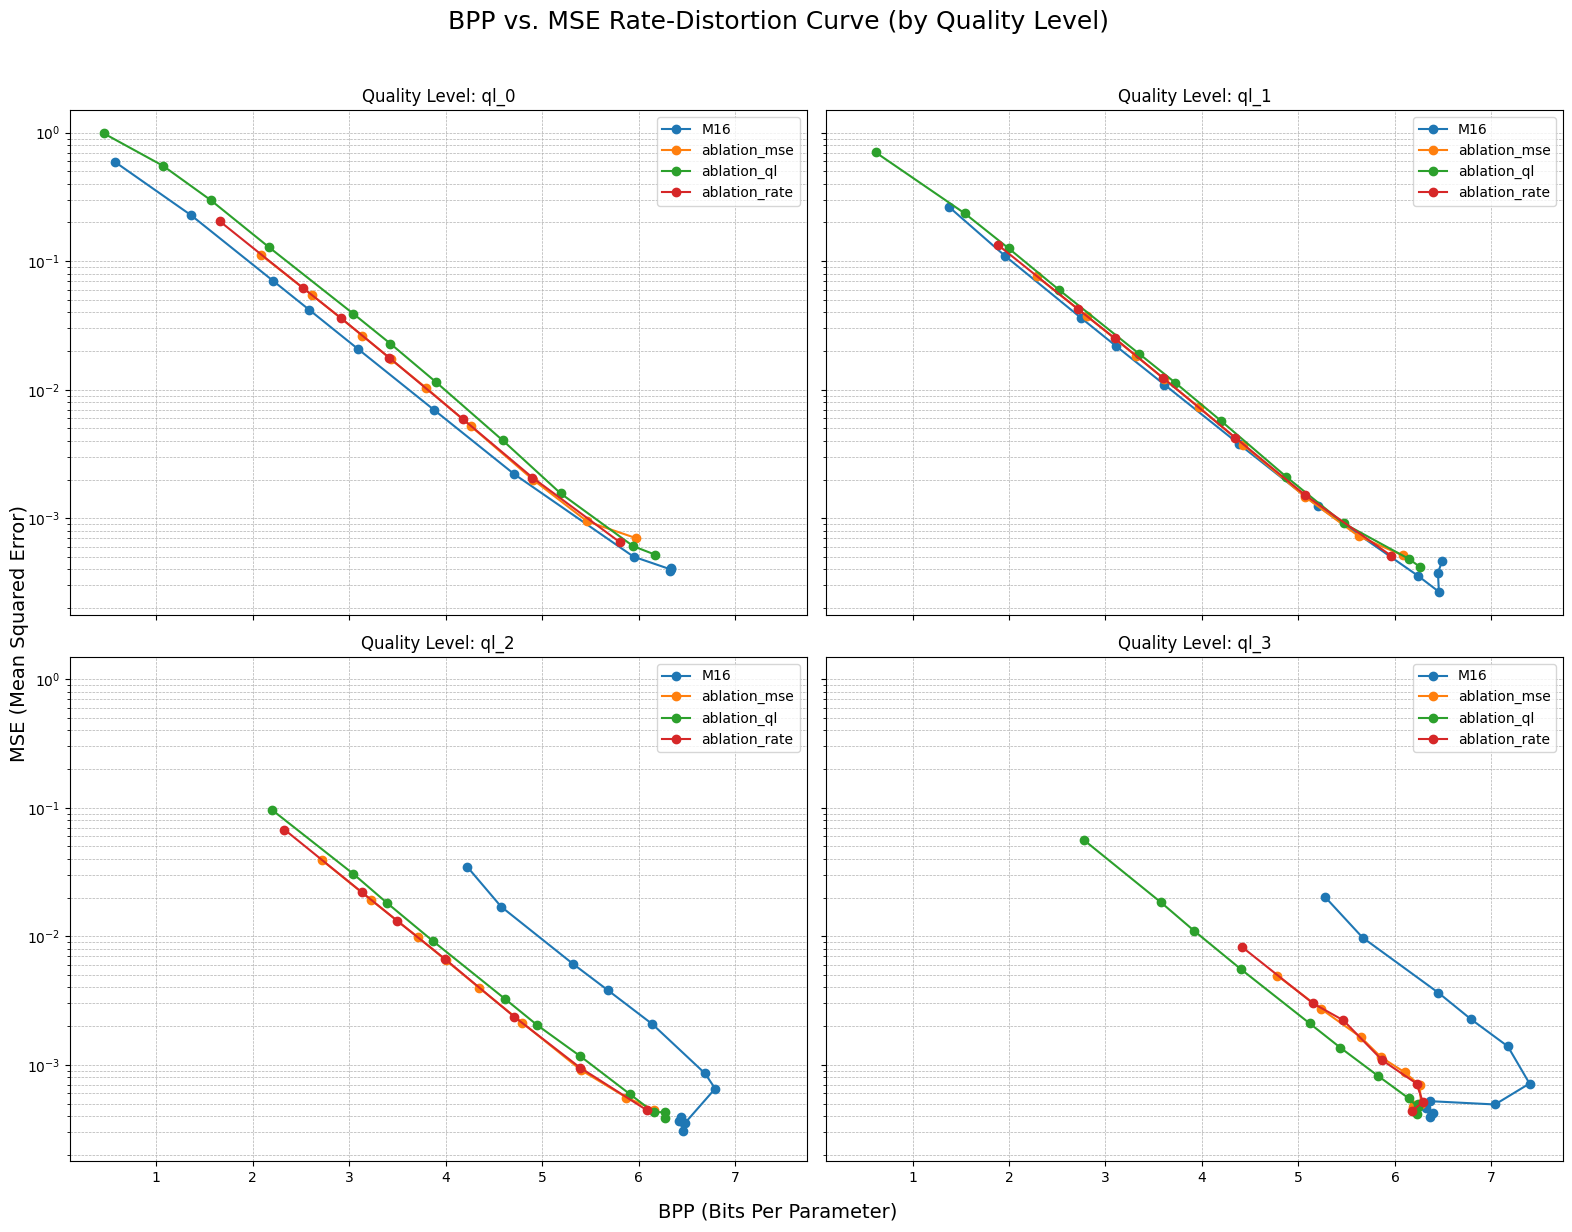

Chart saved successfully to bpp_vs_mse_subplots_matplotlib.png


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# 1. 중첩된 딕셔너리를 리스트로 변환
data_list = []
for exp_name, lmbda_dict in result.items():
    for lmbda_value, ql_dict in lmbda_dict.items():
        for q_level, metrics in ql_dict.items():
            data_list.append({
                'exp_name': exp_name,
                'lmbda': lmbda_value,
                'q_level': q_level, # 'ql_0', 'ql_1', ...
                'mse': metrics['mse'],
                'bpp': metrics['bpp']
            })

# 2. 리스트를 pandas DataFrame으로 변환
df = pd.DataFrame(data_list)

# 3. 데이터 정리
df['lmbda'] = df['lmbda'].astype(int) # 정렬을 위해 lmbda를 정수형으로
print("DataFrame created successfully.")

# 4. Matplotlib 플롯 생성 (2x2 그리드)
print("Generating Matplotlib 2x2 subplot...")
# 2x2=4개의 서브플롯을 생성. sharex=True, sharey=True로 축 공유
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharex=True, sharey=True)

# 5. 각 'q_level'별로 서브플롯에 그리기
q_levels = sorted(df['q_level'].unique()) # ['ql_0', 'ql_1', 'ql_2', 'ql_3']
axes_flat = axes.flatten() # 2D 배열을 1D로 펴서 루프 돌기 쉽게 함

for ax, q_level in zip(axes_flat, q_levels):
    # 현재 q_level에 해당하는 데이터만 필터링
    df_ql = df[df['q_level'] == q_level]
    
    # 현재 서브플롯의 'exp_name' 리스트 가져오기
    exp_names_in_ql = df_ql['exp_name'].unique()
    
    # 각 exp_name (실험) 별로 라인 그리기
    for exp_name in exp_names_in_ql:
        subset = df_ql[df_ql['exp_name'] == exp_name]
        
        # lmbda 순서대로 정렬하여 라인이 올바르게 연결되도록 함
        subset = subset.sort_values(by='lmbda')
        
        ax.plot(subset['bpp'], subset['mse'], marker='o', linestyle='-', label=exp_name)

    # 6. 각 서브플롯 꾸미기
    ax.set_title(f'Quality Level: {q_level}')
    ax.set_yscale('log') # Y축을 로그 스케일로
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend() # 각 서브플롯에 범례 표시

# 7. 전체 플롯 꾸미기
fig.suptitle('BPP vs. MSE Rate-Distortion Curve (by Quality Level)', fontsize=18, y=1.02)
fig.supxlabel('BPP (Bits Per Parameter)', fontsize=14) # 공통 X축 라벨
fig.supylabel('MSE (Mean Squared Error)', fontsize=14) # 공통 Y축 라벨

fig.tight_layout() # 레이아웃 최적화

# 8. 플롯 저장 및 표시
plot_filename = 'bpp_vs_mse_subplots_matplotlib.png'
plt.savefig(plot_filename, bbox_inches='tight')
plt.show()

print(f"Chart saved successfully to {plot_filename}")

Starting data transformation for plotting...
DataFrame created successfully.
Generating Matplotlib subplots (one per lambda)...


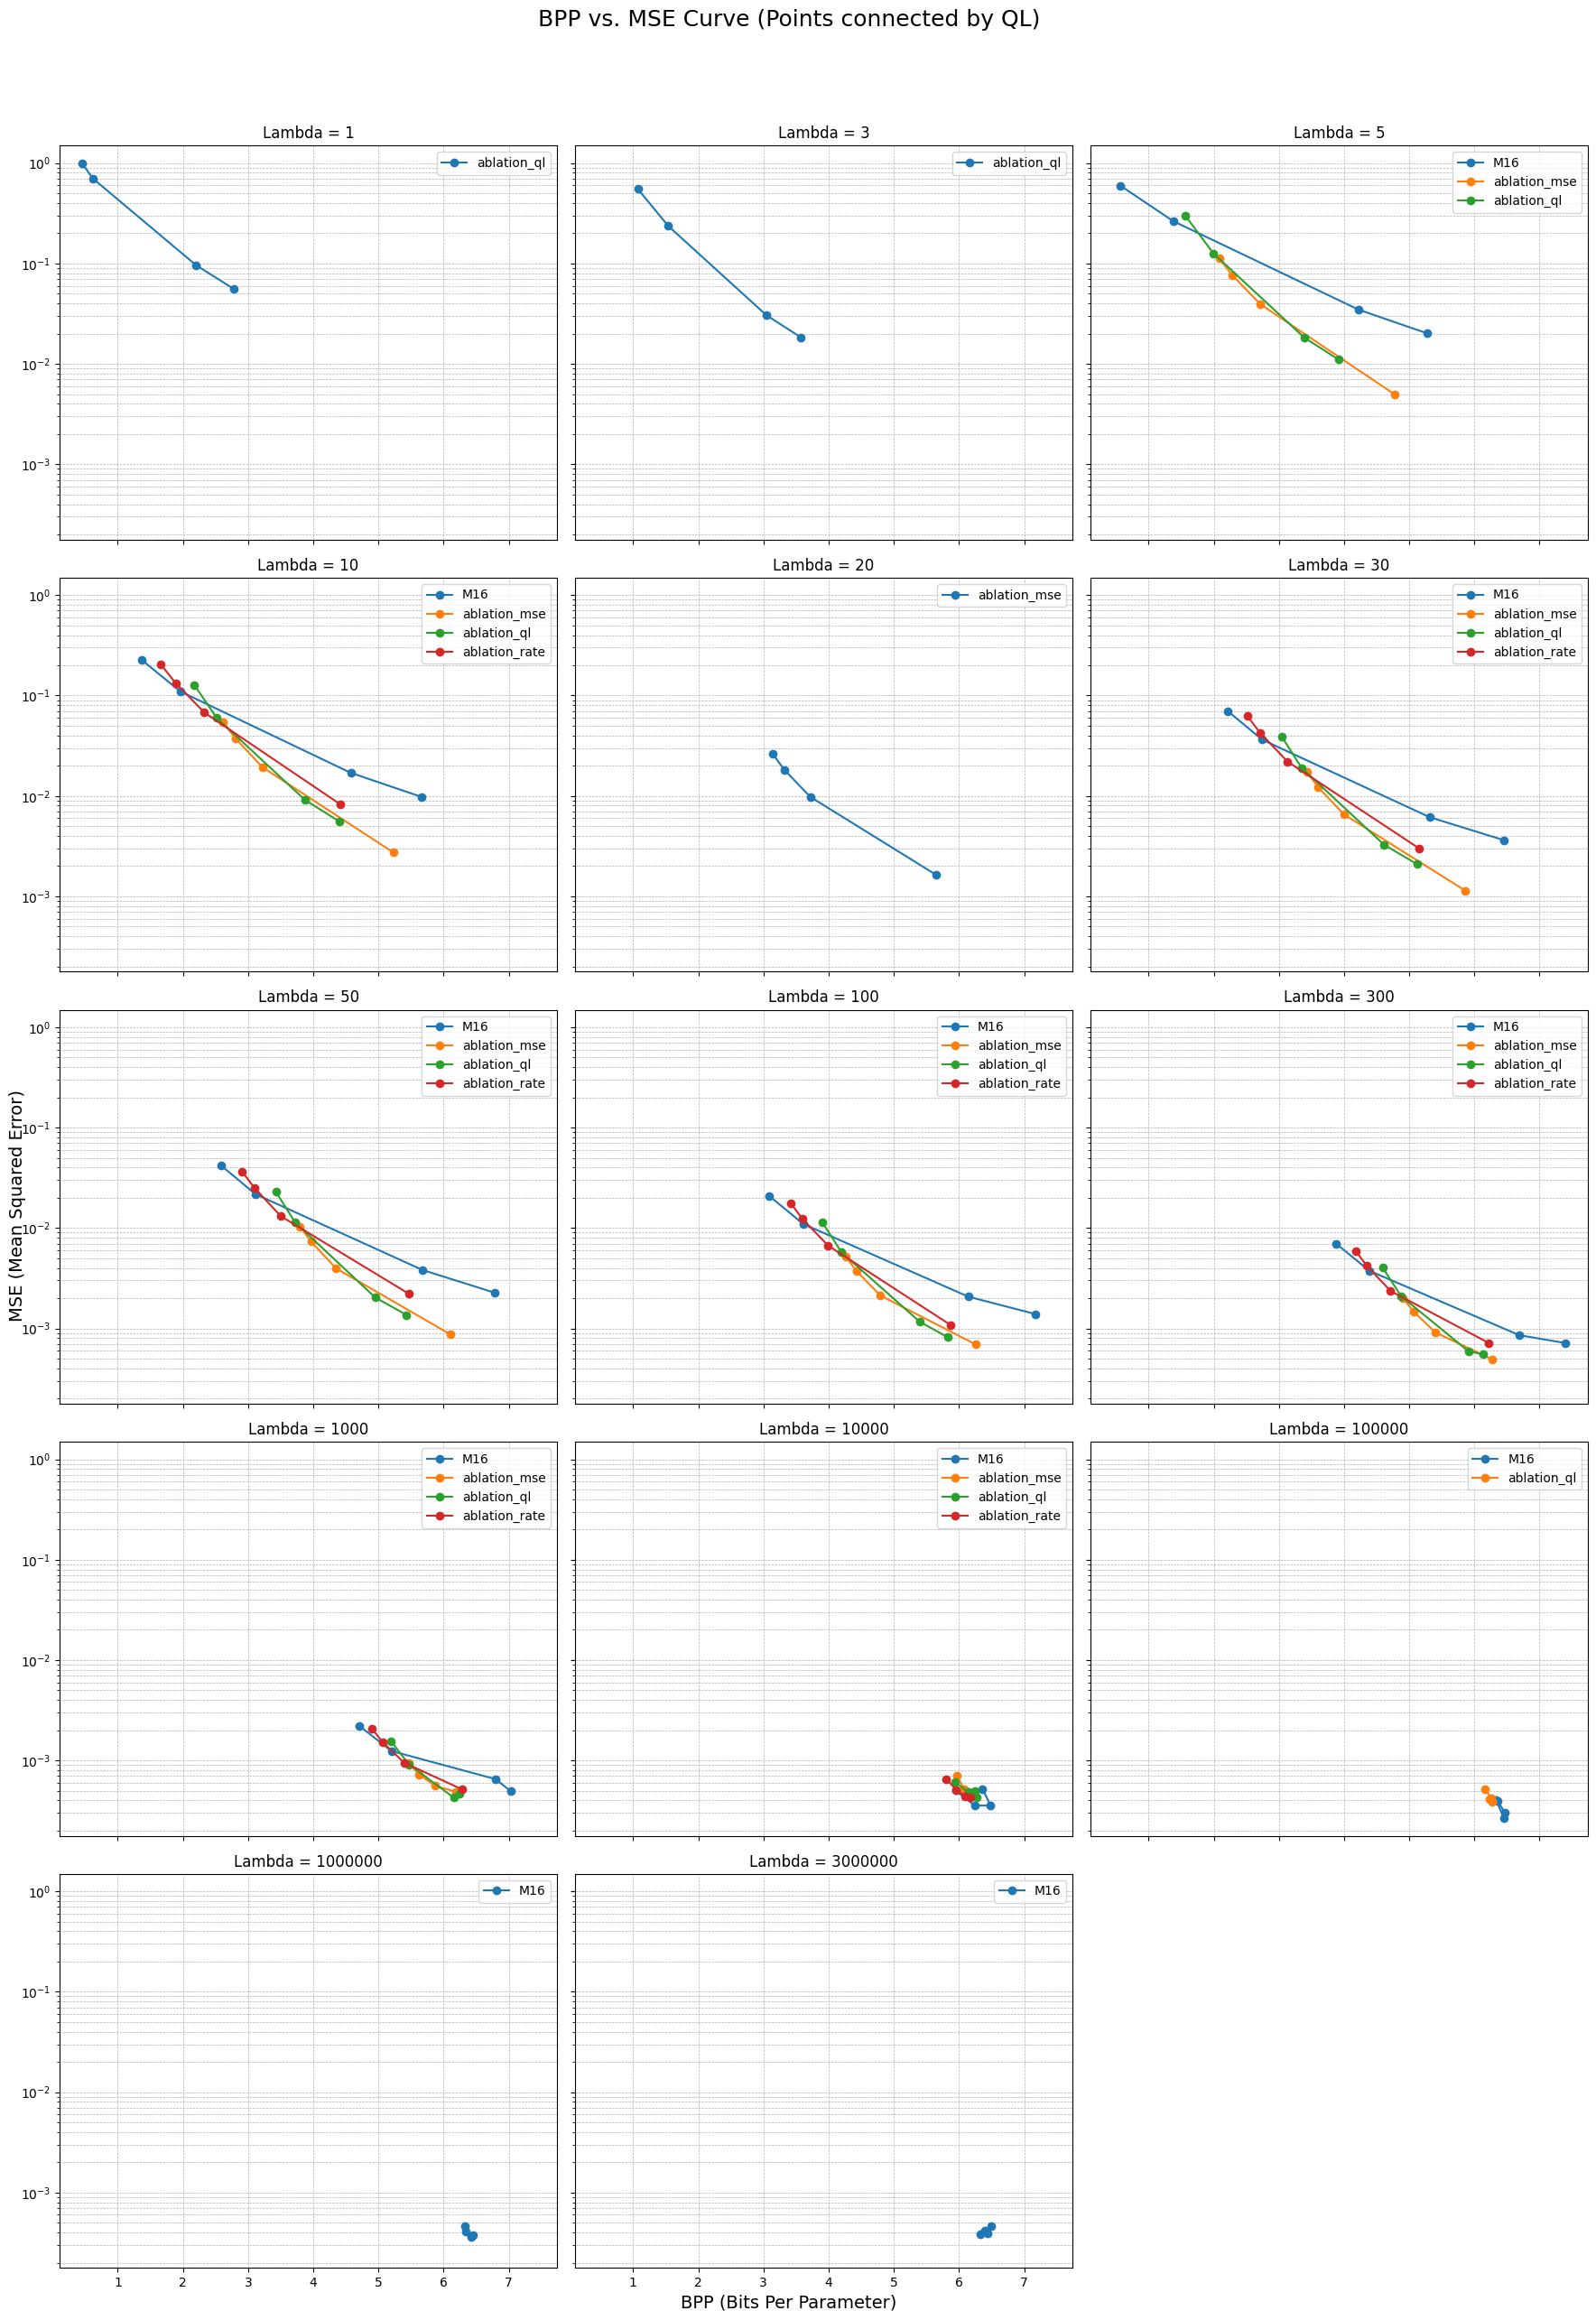

Chart saved successfully to bpp_vs_mse_by_ql_matplotlib.png


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

print("Starting data transformation for plotting...")

# 1. 중첩된 딕셔너리를 리스트로 변환
data_list = []
for exp_name, lmbda_dict in result.items():
    for lmbda_value, ql_dict in lmbda_dict.items():
        for q_level, metrics in ql_dict.items():
            data_list.append({
                'exp_name': exp_name,
                'lmbda': lmbda_value,
                'q_level': q_level, # 'ql_0', 'ql_1', ...
                'mse': metrics['mse'],
                'bpp': metrics['bpp']
            })

# 2. 리스트를 pandas DataFrame으로 변환
df = pd.DataFrame(data_list)

# 3. 데이터 정리
df['lmbda'] = df['lmbda'].astype(int) # lmbda를 정수로 변환 (정렬용)
print("DataFrame created successfully.")

# 4. Matplotlib 플롯 생성 (lmbda 개수만큼)
print("Generating Matplotlib subplots (one per lambda)...")

unique_lambdas = sorted(df['lmbda'].unique())
num_lambdas = len(unique_lambdas)

# 서브플롯 그리드 설정 (예: 3열)
ncols = 3
nrows = math.ceil(num_lambdas / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 5), 
                         sharex=True, sharey=True) # x, y 축 공유
axes_flat = axes.flatten() # 1D 배열로 변환

# 5. 각 'lmbda'별로 서브플롯에 그리기
for i, lmbda in enumerate(unique_lambdas):
    ax = axes_flat[i]
    
    # 현재 lmbda에 해당하는 데이터 필터링
    df_lmbda = df[df['lmbda'] == lmbda]
    
    # 현재 서브플롯의 'exp_name' 리스트 가져오기
    exp_names_in_lmbda = df_lmbda['exp_name'].unique()
    
    # 각 exp_name (실험) 별로 라인 그리기
    for exp_name in exp_names_in_lmbda:
        subset = df_lmbda[df_lmbda['exp_name'] == exp_name]
        
        # 중요: q_level ('ql_0', 'ql_1', ...) 순서대로 정렬
        subset = subset.sort_values(by='q_level')
        
        ax.plot(subset['bpp'], subset['mse'], marker='o', linestyle='-', label=exp_name)

    # 6. 각 서브플롯 꾸미기
    ax.set_title(f'Lambda = {lmbda}')
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()

# 7. 사용하지 않는 서브플롯 숨기기
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].axis('off')

# 8. 전체 플롯 꾸미기
fig.suptitle('BPP vs. MSE Curve (Points connected by QL)', fontsize=18, y=1.03)
fig.supxlabel('BPP (Bits Per Parameter)', fontsize=14)
fig.supylabel('MSE (Mean Squared Error)', fontsize=14)

fig.tight_layout()

# 9. 플롯 저장 및 표시
plot_filename = 'bpp_vs_mse_by_ql_matplotlib.png'
plt.savefig(plot_filename, bbox_inches='tight')
plt.show()

print(f"Chart saved successfully to {plot_filename}")